**Ануфриева Виктория, 5130901/10202**


### *Упражнение 9.1.*

В разделе «Нарастающая сумма» в методических материалах отмечено, что некооторые примеры не работают с апериодическими сигналами.

Рассмотрим эти примеры, подав вместо пилообразного сигнала непериодические данные с биржи о компании Facebook.

Их график выглядит следующим образом:


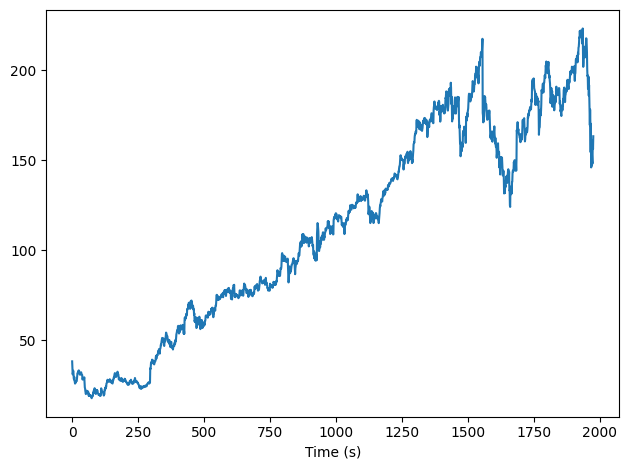

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import decorate, Wave, zero_pad
import pandas as pd

df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
ys = df['Close']
if len(ys) % 2:
    ys = ys[:-1]
in_wave = Wave(ys, framerate=1)
in_wave.plot()
decorate(xlabel='Time (s)')

И выведем спектр полученной волны:

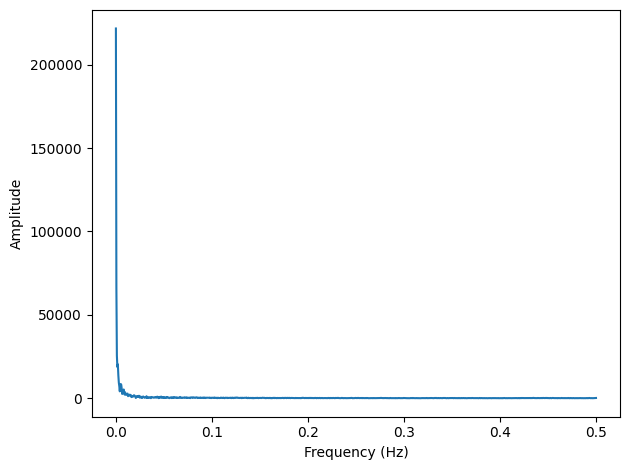

In [3]:
in_spectrum = in_wave.make_spectrum()
in_spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Теперь воспользуемся методом cumsum (аппроксимация к интегрированию).

График приведен ниже:


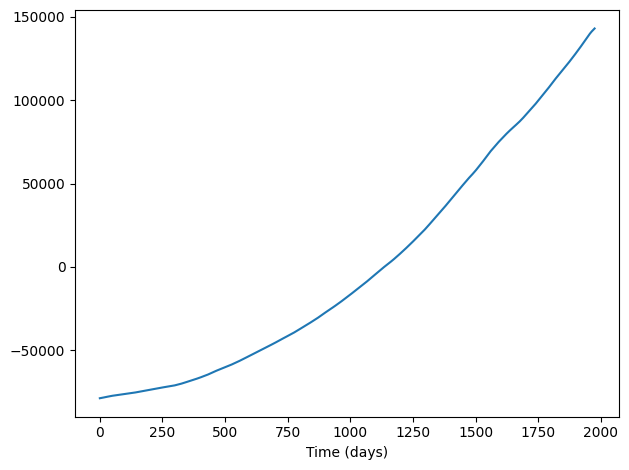

In [6]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Time (days)')

Замечаем резкие отличия графика от того, что представлен в методических материала. У нас получилась просто возрастающая почти прямая линия, но никак не повторющийся сигнал.

Теперь рассмотрим разницу между спектром входной и выходной волны.

Получим следующий график:


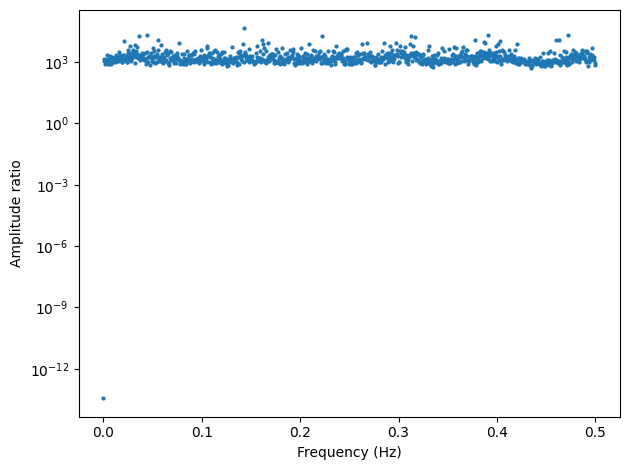

In [8]:
out_spectrum = out_wave.make_spectrum()
ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh=1)
ratio_spectrum.plot(marker='.', ms=4, ls='')

decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

Видно, что вместо кривой с четкой зависимостью, мы получили какие-то хаотичные точки.
Попробуем нормализовать исходную волну - получим следующие графики:


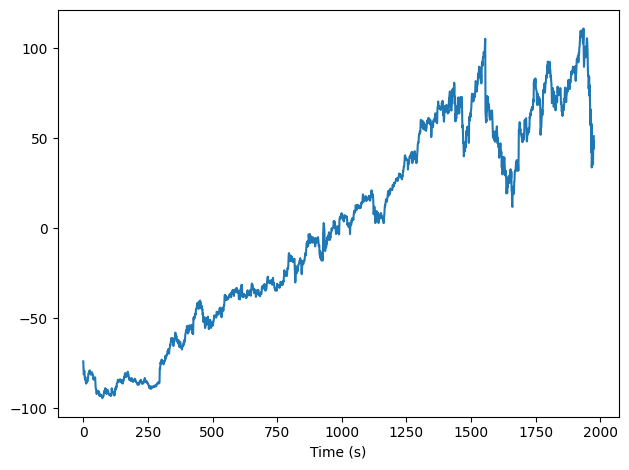

In [32]:
df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
ys = df['Close']
if len(ys) % 2:
    ys = ys[:-1]
in_wave = Wave(ys, framerate=1)
in_wave.unbias()
in_wave.plot()
decorate(xlabel='Time (s)')

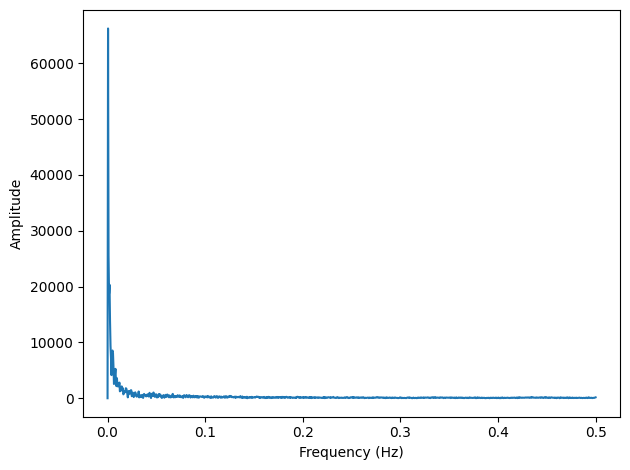

In [33]:
in_spectrum = in_wave.make_spectrum()
in_spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

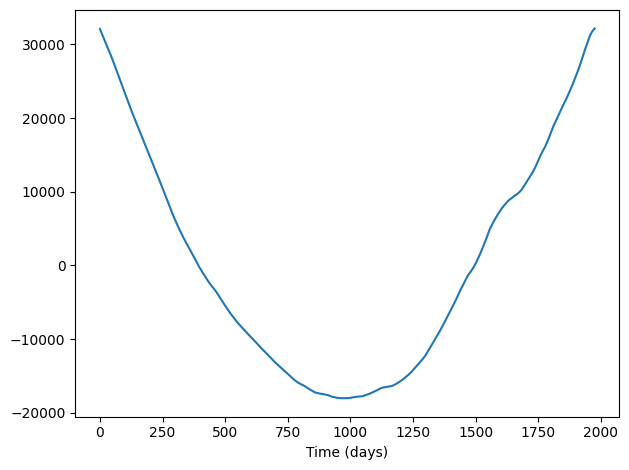

In [34]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Time (days)')

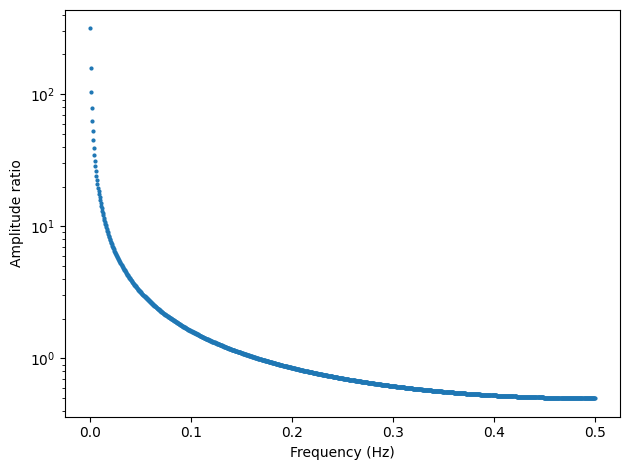

In [35]:
out_spectrum = out_wave.make_spectrum()
ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh = 1)
ratio_spectrum.plot(marker='.', ms=4, ls='')

decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

Теперь полученные графики сравнимы с теми, что представленный в методических материалах. Построим эти кривые на одном графике, чтобы убедиться в корректности построения.

Код из методических материалов и итоговый рисунок:

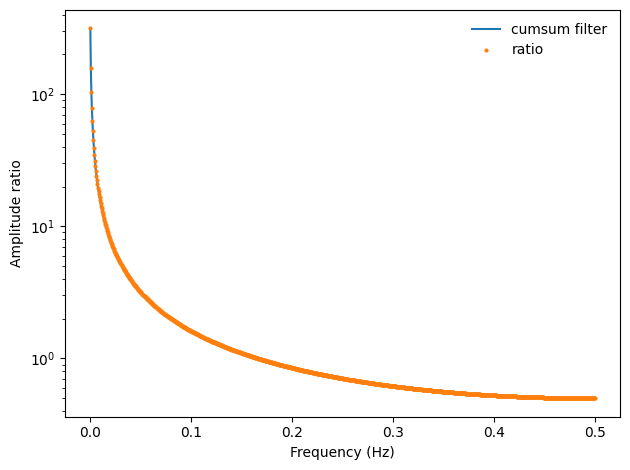

In [36]:
# compute the diff filter
diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()
# compute the cumsum filter by inverting the diff filter
cumsum_filter = diff_filter.copy()
cumsum_filter.hs[1:] = 1 / cumsum_filter.hs[1:]
cumsum_filter.hs[0] = np.inf
cumsum_filter.plot(label='cumsum filter')
ratio_spectrum.plot(label='ratio', marker='.', ms=4, ls='')
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

Рассматривая данный сигнал, затронем теорему о свертке, применив фильтр cumsum в частотной области, а не во временной, и сравним результаты.
  
Ниже представлен получившийся график:

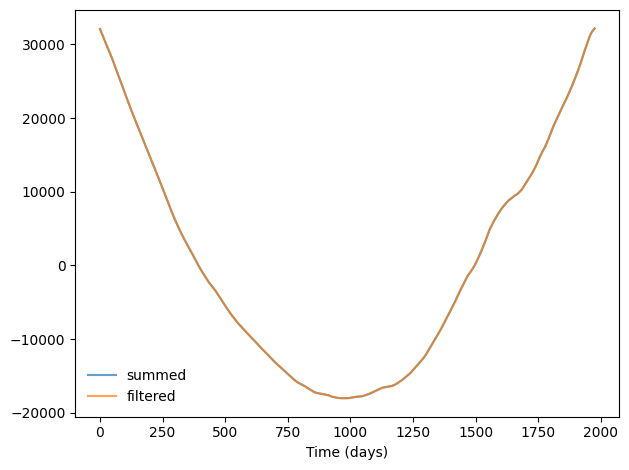

In [37]:
out_wave.plot(label='summed', alpha=0.7)
cumsum_filter.hs[0] = 0
out_wave2 = (in_spectrum * cumsum_filter).make_wave()
out_wave2.plot(label='filtered', alpha=0.7)
decorate(xlabel='Time (days)')

Визуально полученные кривые идеально совпадают друг с другом, а с учетом погрешности вычислений, найденной ниже, сомнений в этом не остаётся.

По результатам работы делаем вывод, что для настоящих нормализованных сигналов данный способ работает верно, но для ненормализированного сигнала сигнал получается абсолюто случайным, непредсказуемым, и такая апроксимация не работает.


In [38]:
out_wave.max_diff(out_wave2)

1.6416379367001355e-10

### *Упражнение 9.2.*

Теперь рассмотрим влияние методов diff и differentiate на сигнал.

Diff – взятие производной через разность между соседними элементами – аппроксимация в временной области.

Differentiate – взятие производной через соответствующую формулу, выведенную в методических материалах, – аппроксимация в частотной области.

Для исследования создадим треугольный сигнал. Он выглядит нам знакомо:


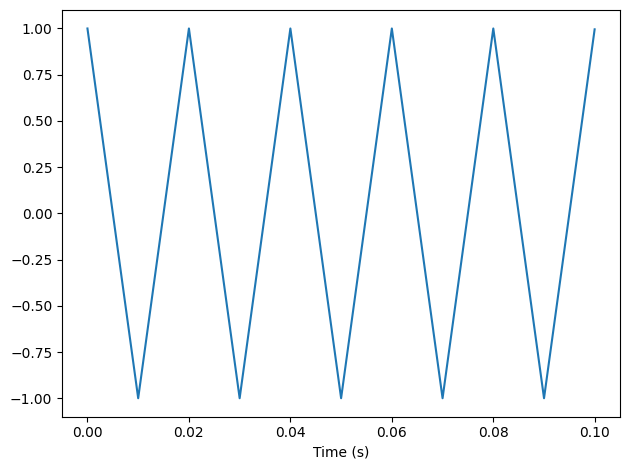

In [39]:
from thinkdsp import TriangleSignal, decorate

in_wave = TriangleSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

Данный сигнал сначала равномерно возрастает, а потом равномерно уменьшается. Поэтому при получении разницы мы должны увидеть одинаковые числа с разными знаками. Убедимся в этом:


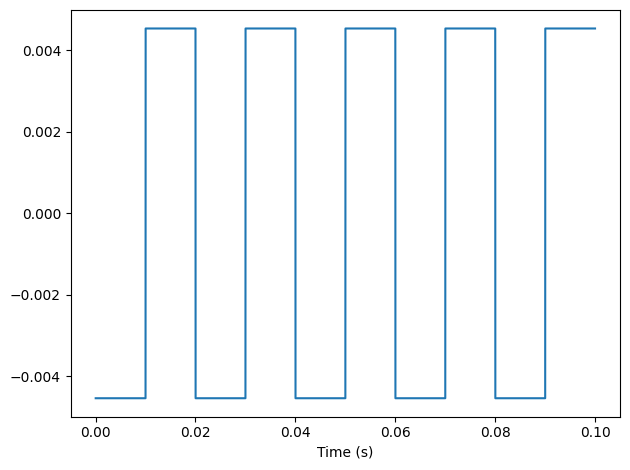

In [40]:
out_wave = in_wave.diff()
out_wave.plot()
decorate(xlabel='Time (s)')

А что мы получим, если применить функцию differentiate:

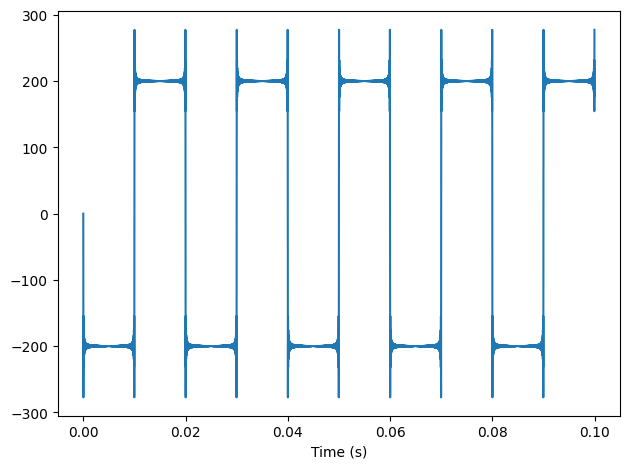

In [41]:
out_wave2 = in_wave.make_spectrum().differentiate().make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

Полученный сигнал похож на предыдущий своей формой, но мы видим «звон» вокруг мест, где на исходном графике находятся углы. Такое поведение вызвано тем, что в этих точках нет производных.

### *Упражнение 9.3.*

Теперь изучим влияние методов cumsum (аппроксимация во временной области) и integrate на сигнал.
Создадим для этого прямоугольный сигнал:


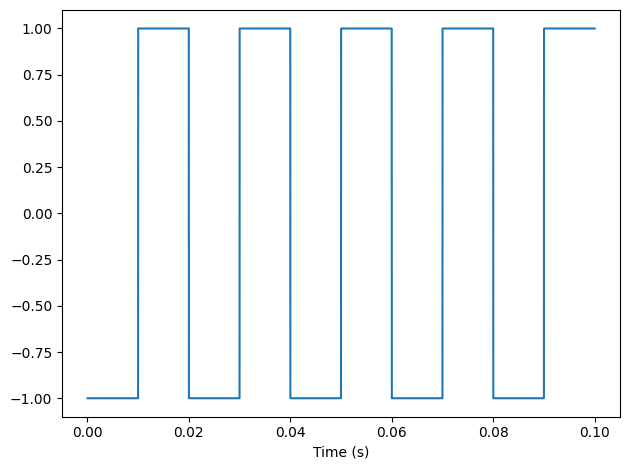

In [42]:
from thinkdsp import SquareSignal, decorate

in_wave = SquareSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

В предыдущем пункте мы увидкли, что производная треугольного сигнала - это прямоугольный, тогда обратная операция интегрирования должна дать на выходе треугольный сигнал.

Проверим наше предположение во временной области и получим следующий график:


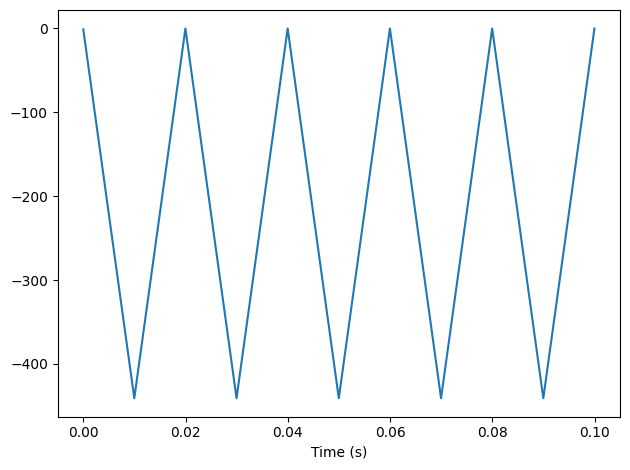

In [43]:
out_wave = in_wave.cumsum()
out_wave.plot()
decorate(xlabel='Time (s)')

Теперь попробуем интегрировать, используя метод integrate в частотной области:


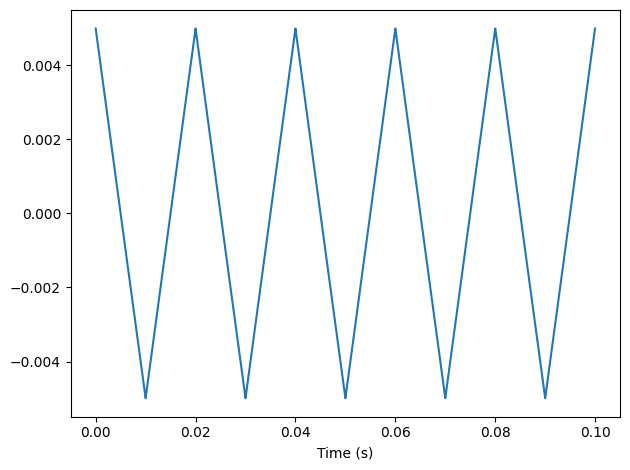

In [44]:
spectrum = in_wave.make_spectrum().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

На первый взгляд полученный сигнал совпадает по форме с предыдущим. Нормируем оба сигнала и посмотрим, совпадают ли они.

Полученный результат представлен ниже:


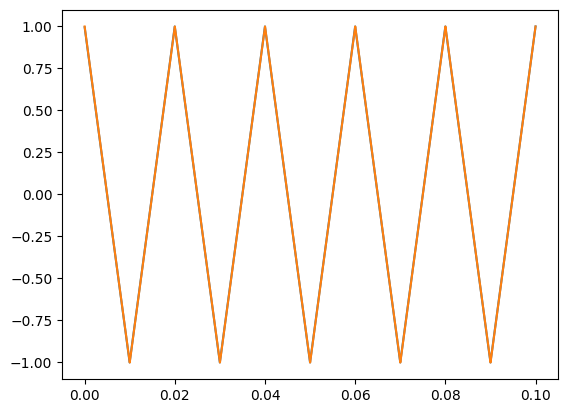

In [48]:
out_wave.unbias()
out_wave.normalize()
out_wave2.normalize()
out_wave.plot()
out_wave2.plot()

Полученные кривые совпадают друг с другом с точностью до погрешности вычислений, найденной ниже.

In [49]:
out_wave.max_diff(out_wave2)

0.0045351473922902175

### *Упражнение 9.4.*

В данном пункте работы рассмотрим то, как изменяется сигнал при двойном интегрировании.

Для исследования создадим пилообразный сигнал:


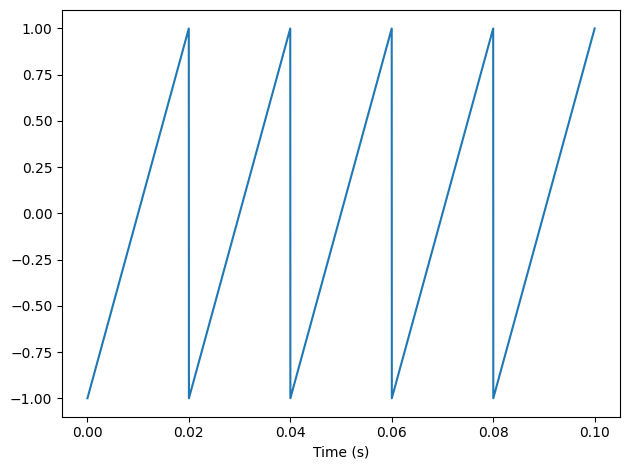

In [50]:
from thinkdsp import SawtoothSignal, decorate
import matplotlib.pyplot as plt

in_wave = SawtoothSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

Интегрируем первый раз методом cumsum:


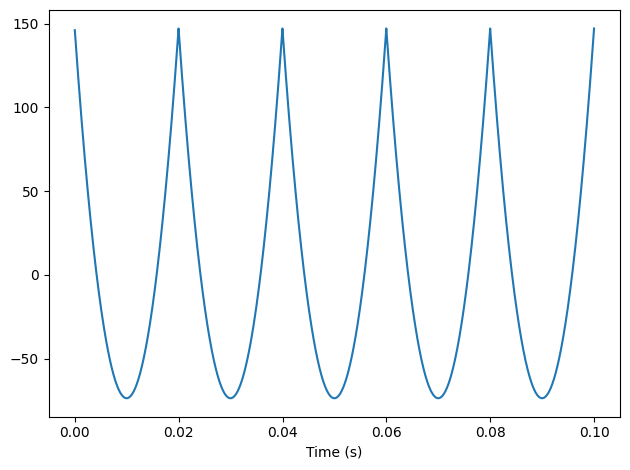

In [51]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Time (s)')

Теперь повторим то же действие и получим второй интеграл.

Итоговый график приведен ниже:


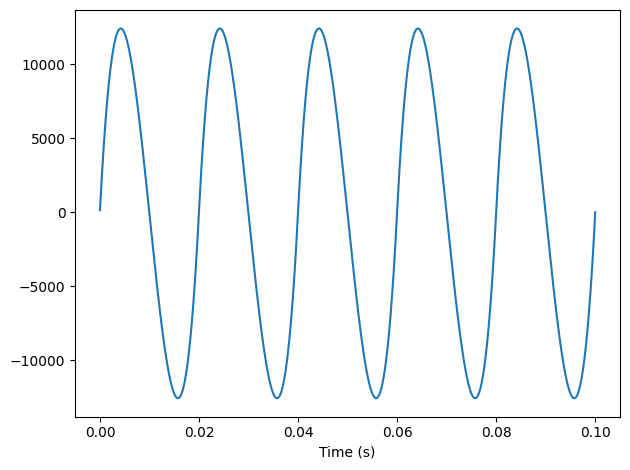

In [52]:
out_wave = out_wave.cumsum()
out_wave.plot()
decorate(xlabel='Time (s)')

Чтобы убедиться в корректности результата, проврим его, используя integrate в частотной области.

Как можно заметить, мы получили аналогичный предыдущему по форме график:


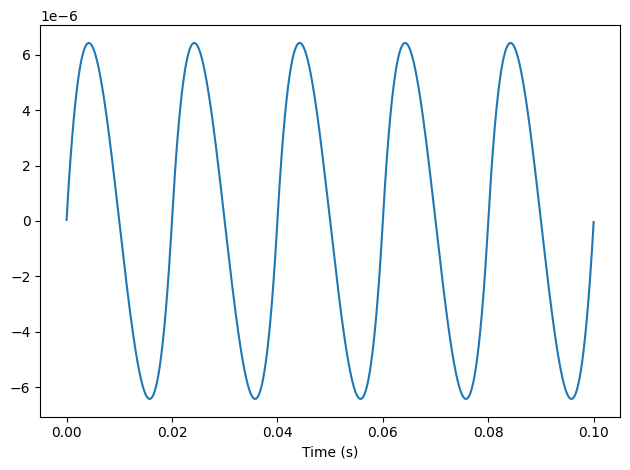

In [53]:
spectrum = in_wave.make_spectrum().integrate().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

По рисунку можно заметить, что сигнал похож на синусоиду. Посмотрим на спектр этого сигнала, чтобы понять, почему так происходит.

Спектры после первого и второго интегрированя соответственно приведёны на рисунках ниже:

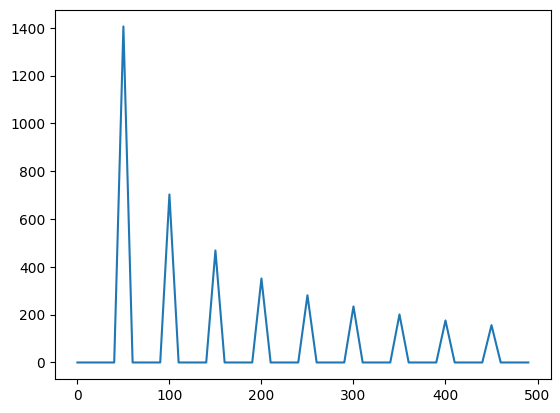

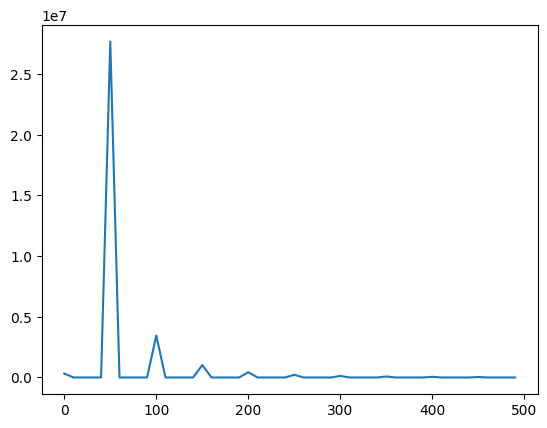

In [54]:
in_wave.make_spectrum().plot(high=500)
plt.show()
out_wave.make_spectrum().plot(high=500)
plt.show()

Исходя из графиков, отметим, что результат интегрирования схож с выходом low_pass фильтра, поэтому после двух интегрирований мы видим практически только один фундаментальный сигнал. Теперь делаем вывод, что основа нашего сигнала – синусоида с фундаментальной частотой.


### *Упражнение 9.5.*

Наконец рассмотрим влияние второй разности и второй производной.

Создадим для исследования CubicSignal. Он выглядит так:


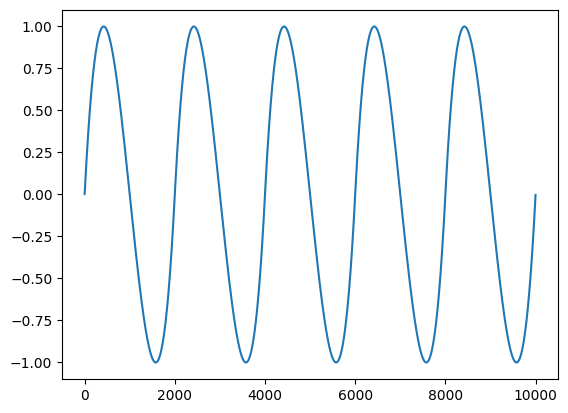

In [55]:
from thinkdsp import CubicSignal, decorate

in_wave = CubicSignal(freq=0.0005).make_wave(duration=10000, framerate=1)
in_wave.plot()

Теперь возьмем первую и вторую разность:


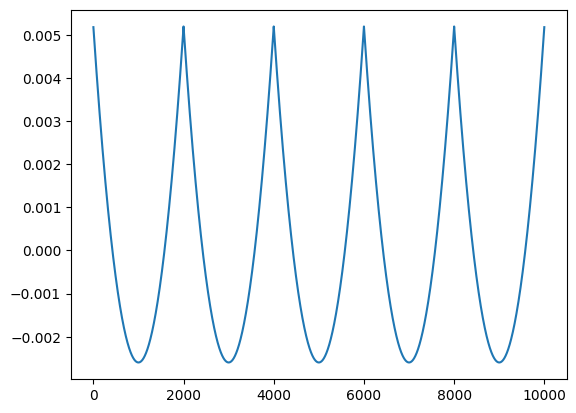

In [56]:
out_wave = in_wave.diff()
out_wave.plot()

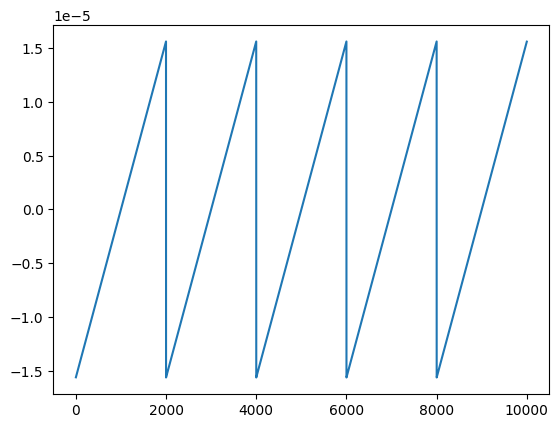

In [57]:
out_wave = out_wave.diff()
out_wave.plot()

Как и ожидалось, мы получили пилообразный сигнал. Такой результат можно было предположить, т.к. в предыдущем пункте мы, наоборот, получили из пилообразного CubricSignal.

Далее используем метод differentiate и сравним с полученным нами сигналом:


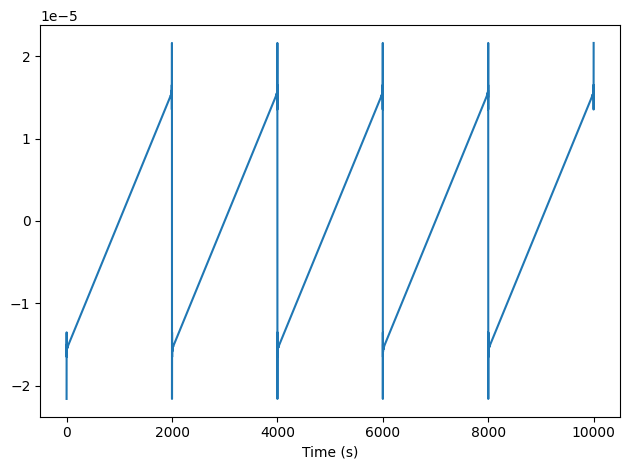

In [58]:
spectrum = in_wave.make_spectrum().differentiate().differentiate()
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

Не считая неопределённость производной в точках перегиба, в результате мы получили практически идентичные графики.

Далее нам необходимо сравнить фильтры второй производной и второй разности.

Код для фильтра второй разности и его результат представлены ниже:


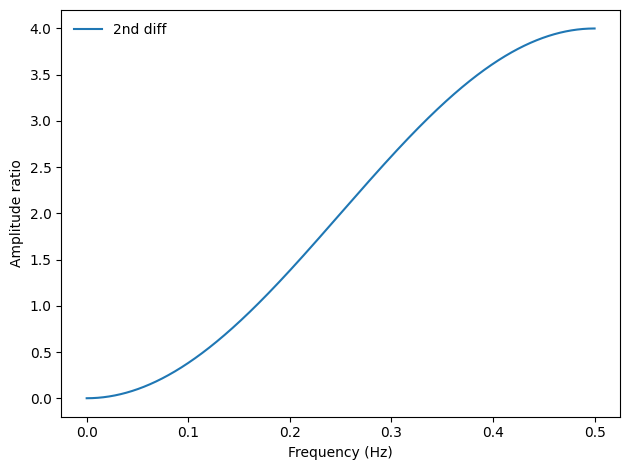

In [59]:
from thinkdsp import zero_pad
from thinkdsp import Wave, PI2
import numpy as np

diff_window = np.array([-1.0, 2.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()
diff_filter.plot(label='2nd diff')

decorate(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio')

Аналогичный график выведем для второй производной:


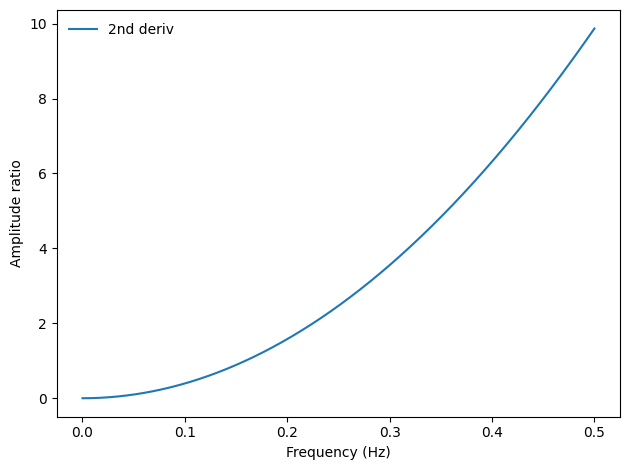

In [60]:
deriv_filter = in_wave.make_spectrum()
deriv_filter.hs = (PI2 * 1j * deriv_filter.fs)**2
deriv_filter.plot(label='2nd deriv')

decorate(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio')

Для удобства сравнения выведем оба графика вместе:


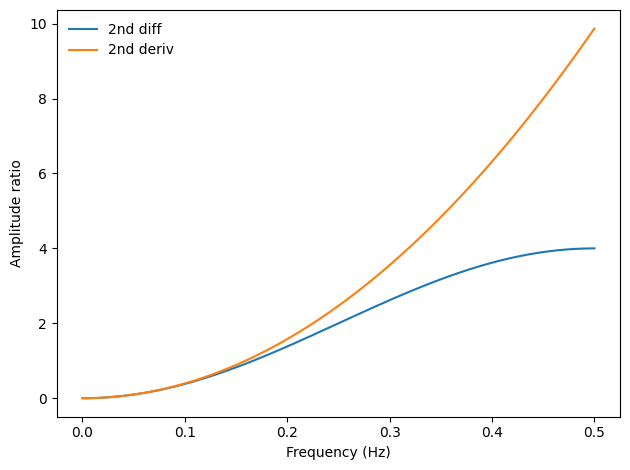

In [61]:
diff_filter.plot(label='2nd diff')
deriv_filter.plot(label='2nd deriv')

decorate(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio')

Изученные в данном пункте работы фильтры схожи с high_pass фильтрами.

Как мы видим на графике, вторая разность даёт хорошее приближение ко второй производной только на низких частотах сигнала, но чем выше частота, тем значительнее различия.